# 1. Load Data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Thư mục chứa các file signal
folder_0_subject = '../../dataset/raw/0_subject'
all_files = [f for f in os.listdir(folder_0_subject) if f.endswith('.txt')]

print(f"Found {len(all_files)} .txt files.")

Found 657 .txt files.


# 2. Xlsx & Csv

In [4]:
# Hàm Skewness
def calculate_ssqi(signal):
    N = len(signal)
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    skewness = (1 / N) * np.sum(((signal - mean_signal) / std_signal) ** 3)
    return skewness

# Hàm tìm giá trị max y trong file tín hiệu
def get_max_y(subject_id, signal_type):
    file_name = f"{int(subject_id)}_{int(signal_type)}.txt"  # Chuyển thành số nguyên
    file_path = os.path.join(folder_0_subject, file_name)

    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            data = file.read().split()
        signal = np.array(data, dtype=float)
        return np.max(signal)  # Trả về giá trị lớn nhất của tín hiệu
    else:
        print(f"File {file_name} không tồn tại.")
        return None

# Hàm tìm giá trị min y trong file tín hiệu
def get_min_y(subject_id, signal_type):
    file_name = f"{int(subject_id)}_{int(signal_type)}.txt"  # Chuyển thành số nguyên
    file_path = os.path.join(folder_0_subject, file_name)
    

    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            data = file.read().split()
        signal = np.array(data, dtype=float)
        return np.min(signal)  # Trả về giá trị nhỏ nhất của tín hiệu
    else:
        print(f"File {file_name} không tồn tại.")
        return None

# Khởi tạo dictionary để lưu kết quả SSQI cho từng subject
ssqi_data = {}

# Duyệt qua tất cả các file tín hiệu trong folder
all_files = [f for f in os.listdir(folder_0_subject) if f.endswith('.txt')]

for file_name in all_files:
    file_path = os.path.join(folder_0_subject, file_name)

    # Đọc dữ liệu tín hiệu từ file
    with open(file_path, 'r') as file:
        data = file.read().split()
    signal = np.array(data, dtype=float)

    # Tính SSQI cho tín hiệu
    ssqi_value = calculate_ssqi(signal)

    # Lấy Subject_ID và loại tín hiệu từ tên file
    subject_id = int(file_name.split('_')[0])
    signal_type = int(file_name.split('_')[1].split('.')[0])

    # Lưu kết quả vào dictionary
    if subject_id not in ssqi_data:
        ssqi_data[subject_id] = {'SSQI_sig1': None, 'SSQI_sig2': None, 'SSQI_sig3': None}
    ssqi_data[subject_id][f'SSQI_sig{signal_type}'] = ssqi_value

# Chuyển SSQI dữ liệu thành DataFrame
ssqi_df = pd.DataFrame.from_dict(ssqi_data, orient='index').reset_index()
ssqi_df.rename(columns={'index': 'Subject_ID'}, inplace=True)

# Xác định Max SQI và tín hiệu tương ứng
ssqi_df['Max SQI'] = ssqi_df[['SSQI_sig1', 'SSQI_sig2', 'SSQI_sig3']].max(axis=1)
ssqi_df['Max SQI Signal'] = ssqi_df[['SSQI_sig1', 'SSQI_sig2', 'SSQI_sig3']].idxmax(axis=1)

# Chuyển đổi giá trị trong 'Max SQI Signal' thành số
ssqi_df['Max SQI Signal'] = ssqi_df['Max SQI Signal'].str.extract('(\d+)').astype(int)

# Tạo cột `max_y` bằng cách tìm giá trị lớn nhất trong file Max SQI signal
def get_max_y_for_row(row):
    subject_id = row['Subject_ID']
    signal_type = row['Max SQI Signal']  # Lấy loại tín hiệu (1, 2 hoặc 3)
    return get_max_y(subject_id, signal_type)

# Tạo cột `min_y` bằng cách tìm giá trị nhỏ nhất trong file Max SQI signal
def get_min_y_for_row(row):
    subject_id = row['Subject_ID']
    signal_type = row['Max SQI Signal']  # Lấy loại tín hiệu (1, 2 hoặc 3)
    return get_min_y(subject_id, signal_type)

ssqi_df['max_y'] = ssqi_df.apply(get_max_y_for_row, axis=1)
ssqi_df['min_y'] = ssqi_df.apply(get_min_y_for_row, axis=1)

# Đọc thông tin bệnh nhân từ file Excel
subject_info = pd.read_excel('../../dataset/raw/PPG-BP dataset.xlsx')

# Kết hợp SSQI với thông tin bệnh nhân
final_df = pd.merge(ssqi_df, subject_info[['Num.', 'subject_ID', 'Hypertension']], 
                    left_on='Subject_ID', right_on='subject_ID', how='left')

# Đổi tên cột và sắp xếp theo Num
final_df.rename(columns={'Num.': 'Num', 'Hypertension': 'Label'}, inplace=True)
final_df = final_df.sort_values(by='Num').reset_index(drop=True)

# Chọn các cột cần thiết
final_df = final_df[['Num', 'Subject_ID', 'SSQI_sig1', 'SSQI_sig2', 'SSQI_sig3', 
                     'Label', 'Max SQI', 'Max SQI Signal', 'max_y', 'min_y']]

# Lưu DataFrame vào Excel và CSV
final_df.to_excel('../../results/PPG_SQI_Results.xlsx', index=False)
final_df.to_csv('../../results/PPG_SQI_Results.csv', index=False)

print("Bảng dữ liệu đã được lưu vào PPG_SQI_Results.xlsx và PPG_SQI_Results.csv")

Bảng dữ liệu đã được lưu vào PPG_SQI_Results.xlsx và PPG_SQI_Results.csv


In [5]:
import os
import pandas as pd
import shutil

# Đường dẫn
PPG_SQI_file = '../../results/PPG_SQI_Results.xlsx'
folder_0_subject = '../../dataset/raw/0_subject'
folder_0_subjectSQI = '../../results/0_subjectSQI'  # folder lưu file Max SQI

# Đảm bảo thư mục đích tồn tại
if not os.path.exists(folder_0_subjectSQI):
    os.makedirs(folder_0_subjectSQI)

# Đọc file Excel chứa thông tin Max SQI
df = pd.read_excel(PPG_SQI_file)

# Lặp qua từng dòng để tìm file .txt có Max SQI và sao chép
missing_files = []  # Danh sách file bị thiếu
for index, row in df.iterrows():
    subject_id = int(row['Subject_ID'])  # ID bệnh nhân
    signal_type = int(row['Max SQI Signal'])  # Loại tín hiệu (1, 2, hoặc 3)
    
    # Xác định tên file .txt
    file_name = f"{subject_id}_{signal_type}.txt"
    src_path = os.path.join(folder_0_subject, file_name)
    dest_path = os.path.join(folder_0_subjectSQI, file_name)
    
    # Sao chép file nếu tồn tại
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
        print(f"File have been copied: {file_name}")
    else:
        missing_files.append(file_name)

# Kết quả
if missing_files:
    print("The following file is not exist:")
    for missing_file in missing_files:
        print(missing_file)
else:
    print("Copy process complete. All max SQI files have been saved to the 0_subjectSQI folder.")


File have been copied: 2_3.txt
File have been copied: 3_1.txt
File have been copied: 6_3.txt
File have been copied: 8_1.txt
File have been copied: 9_3.txt
File have been copied: 10_1.txt
File have been copied: 11_1.txt
File have been copied: 12_2.txt
File have been copied: 13_3.txt
File have been copied: 14_2.txt
File have been copied: 15_1.txt
File have been copied: 16_3.txt
File have been copied: 17_3.txt
File have been copied: 18_3.txt
File have been copied: 19_1.txt
File have been copied: 21_3.txt
File have been copied: 22_2.txt
File have been copied: 23_3.txt
File have been copied: 24_1.txt
File have been copied: 25_1.txt
File have been copied: 26_1.txt
File have been copied: 27_3.txt
File have been copied: 29_2.txt
File have been copied: 30_1.txt
File have been copied: 31_2.txt
File have been copied: 32_3.txt
File have been copied: 34_1.txt
File have been copied: 35_3.txt
File have been copied: 38_3.txt
File have been copied: 40_2.txt
File have been copied: 41_2.txt
File have bee

# 3. Normalize and Visualize .txt to Signal Image file

In [6]:
images_signal = '../../images/images_signal'

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel(PPG_SQI_file)

max_y_global = df['max_y'].max()
min_y_global = df['min_y'].min()
print(f"Global max amplitute: {max_y_global}")
print(f"Global min amplitute: {min_y_global}")

Global max amplitute: 4011
Global min amplitute: 1394


## Normalize

In [8]:
# Hàm chuyển đổi label thành thư mục
def map_label_to_folder(label):
    if label == 'Normal':
        return 'Normal'
    elif label == 'Stage 1 hypertension':
        return 'Stage 1 hypertension'
    elif label == 'Stage 2 hypertension':
        return 'Stage 2 hypertension'
    elif label == 'Prehypertension':
        return 'Prehypertension'
    else:
        return 'Unknown'
    
# Hàm chuẩn hóa max min amplitute về 0-1
def normalize_signal(signal, min_y_global, max_y_global):
    return (signal - min_y_global) / (max_y_global - min_y_global)

def plot_signal(subject_id, signal_type, label, min_y_global, max_y_global):
    # Tạo tên file txt dựa trên subject_id và signal_type (ví dụ: 2_3.txt)
    file_name = f"{subject_id}_{signal_type}.txt"
    PPG_file = os.path.join(folder_0_subject, file_name)
    
    if not os.path.exists(PPG_file):
        print(f"File {file_name} không tồn tại.")
        return
    
    # Đọc tín hiệu từ file txt
    with open(PPG_file, 'r') as file:
        data = file.read().split()
    signal = np.array(data, dtype=float)

    # Normalize to 0-1
    normalized_signal = normalize_signal(signal, min_y_global, max_y_global)

    plt.figure(figsize=(10, 4))
    plt.plot(normalized_signal)
    plt.ylim([0, 1])

    # Tạo tên thư mục con dựa trên nhãn (label) đã được map lại
    folder_name = map_label_to_folder(label)
    label_folder = os.path.join(images_signal, folder_name)
    
    if not os.path.exists(label_folder):
        os.makedirs(label_folder)

    # Lưu ảnh vào thư mục con theo nhãn
    image_path = os.path.join(label_folder, f"{subject_id}_{signal_type}.png")
    plt.savefig(image_path)
    plt.close()  # Đóng biểu đồ để tiết kiệm bộ nhớ
    print(f"Saved fig for subject {subject_id}, Signal {signal_type} at {image_path}")

# Lặp qua tất cả các bệnh nhân trong DataFrame và vẽ biểu đồ
for index, row in df.iterrows(): 
    subject_id = row['Subject_ID']
    max_signal = row['Max SQI Signal']  # Ví dụ: 'SSQI_sig3'
    label = row['Label']
    
    # Lấy loại tín hiệu từ tên (loại 1, 2, hoặc 3)
    signal_type = int(max_signal)
    
    # Hàm plot_signal
    plot_signal(subject_id, signal_type, label, min_y_global, max_y_global)

Saved fig for subject 2, Signal 3 at ../../images/images_signal\Stage 2 hypertension\2_3.png
Saved fig for subject 3, Signal 1 at ../../images/images_signal\Stage 2 hypertension\3_1.png
Saved fig for subject 6, Signal 3 at ../../images/images_signal\Normal\6_3.png
Saved fig for subject 8, Signal 1 at ../../images/images_signal\Prehypertension\8_1.png
Saved fig for subject 9, Signal 3 at ../../images/images_signal\Prehypertension\9_3.png
Saved fig for subject 10, Signal 1 at ../../images/images_signal\Prehypertension\10_1.png
Saved fig for subject 11, Signal 1 at ../../images/images_signal\Prehypertension\11_1.png
Saved fig for subject 12, Signal 2 at ../../images/images_signal\Normal\12_2.png
Saved fig for subject 13, Signal 3 at ../../images/images_signal\Normal\13_3.png
Saved fig for subject 14, Signal 2 at ../../images/images_signal\Normal\14_2.png
Saved fig for subject 15, Signal 1 at ../../images/images_signal\Prehypertension\15_1.png
Saved fig for subject 16, Signal 3 at ../../im

# 4. Spectrum

## 4.1 FFT, PSD, Spectrogram

In [9]:
from scipy.signal import welch
from PIL import Image

images_spectrum = '../../images/images_spectrum'
sampling_rate = 1000

In [11]:
df = pd.read_excel('../../results/PPG_SQI_Results.xlsx')

# Đảm bảo thư mục images_spectrum tồn tại
if not os.path.exists(images_spectrum):
    os.makedirs(images_spectrum)

category_mapping = {
    'Normal': 'Normal',
    'Prehypertension': 'Prehypertension',
    'Stage1': 'Stage1',
    'Stage2': 'Stage2'
}

In [ ]:
# # Hàm chuyển ảnh thành tín hiệu
# def extract_signal_from_image(image_path):
#     image = Image.open(image_path).convert('L')
#     image_data = np.array(image)
#     signal = np.mean(image_data, axis=1) - np.mean(image_data, axis=1).mean()
#     return signal

# # Hàm tính FFT
# def apply_fft(signal):
#     fft_result = np.fft.fft(signal)
#     freq = np.fft.fftfreq(len(signal), d=1/sampling_rate)
#     return freq, np.abs(fft_result)

# # Hàm tính PSD
# def apply_psd(signal):
#     freq, psd = welch(signal, fs=sampling_rate, nperseg=256)
#     return freq, psd

# # Hàm vẽ Spectrogram
# def plot_spectrogram(signal):
#     plt.specgram(signal, Fs=sampling_rate, NFFT=256, noverlap=128, cmap='jet')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Frequency (Hz)')
#     plt.colorbar(label='Intensity')

In [ ]:
# # Tìm giá trị y lớn nhất trên tất cả các bệnh nhân
# max_y = 0
# for category in os.listdir(images_signal):
#     category_folder = os.path.join(images_signal, category)
#     if os.path.isdir(category_folder):
#         for file_name in os.listdir(category_folder):
#             file_path = os.path.join(category_folder, file_name)
            
#             # Chuyển đổi ảnh thành tín hiệu và áp dụng FFT
#             if os.path.exists(file_path):
#                 signal = extract_signal_from_image(file_path)
#                 _, fft_magnitude = apply_fft(signal)
                
#                 # Cập nhật max_y nếu có giá trị cao hơn
#                 max_y = max(max_y, np.max(fft_magnitude))

# print(f"Global max y for all patients: {max_y}")

In [63]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import welch
# from PIL import Image

# # Đọc thông tin từ file Excel và lặp qua các bệnh nhân
# for index, row in df.iterrows():
#     subject_id = row['Subject_ID']
#     max_signal = row['Max SQI Signal']  # Bây giờ chỉ là số nguyên
#     label = row['Label']

#     label_folder_name = category_mapping.get(label, label)
#     signal_type = int(max_signal)  # Trực tiếp dùng giá trị số
#     image_filename = f"{subject_id}_{signal_type}.png"
#     image_path = os.path.join(images_signal, label_folder_name, image_filename)

#     if os.path.exists(image_path):
#         signal = extract_signal_from_image(image_path)

#         # FFT
#         freq, fft_magnitude = apply_fft(signal)
#         plt.figure(figsize=(6, 4))
#         plt.plot(freq[:len(freq)//2], fft_magnitude[:len(freq)//2], label='FFT')
#         plt.xlabel('Frequency (Hz)')
#         plt.ylabel('Amplitude')
#         plt.title(f'Spectrum Analysis (FFT) - {label} - Subject {subject_id}')
#         plt.xlim([0, 50])
#         plt.ylim([0, 1200])
#         plt.legend()
#         plt.grid(True)
#         fft_path = os.path.join(images_spectrum, label_folder_name, f"{subject_id}_{signal_type}_FFT.png")
#         plt.savefig(fft_path)
#         plt.close()

#         # PSD
#         freq, psd = apply_psd(signal)
#         plt.figure(figsize=(6, 4))
#         plt.plot(freq, psd, label='PSD')
#         plt.xlabel('Frequency (Hz)')
#         plt.ylabel('Power Spectral Density')
#         plt.title(f'Spectrum Analysis (PSD) - {label} - Subject {subject_id}')
#         plt.xlim([0, 50])
#         plt.legend()
#         plt.grid(True)
#         psd_path = os.path.join(images_spectrum, label_folder_name, f"{subject_id}_{signal_type}_PSD.png")
#         plt.savefig(psd_path)
#         plt.close()

#         # Spectrogram
#         plt.figure(figsize=(6, 4))
#         plot_spectrogram(signal)
#         plt.title(f'Spectrum Analysis (Spectrogram) - {label} - Subject {subject_id}')
#         spectrogram_path = os.path.join(images_spectrum, label_folder_name, f"{subject_id}_{signal_type}_Spectrogram.png")
#         plt.savefig(spectrogram_path)
#         plt.close()

#         print(f"Lưu phổ FFT, PSD, và Spectrogram cho Subject {subject_id}, {label}")
#     else:
#         print(f"File {image_path} không tồn tại.")

## Spectrum from .txt

### Normalize SQI .txt file

In [12]:
# folder_0_subjectSQI = '../0_subjectSQI'
folder_normalized = '../../dataset/normalization/0_subjectSQI_normalized'  # Thư mục lưu file normalize

# Đảm bảo thư mục đích tồn tại
if not os.path.exists(folder_normalized):
    os.makedirs(folder_normalized)

# Tìm giá trị min và max toàn cục từ tất cả các file
global_min = float('inf')
global_max = float('-inf')

# Bước 1: Tìm global min và max
for file_name in os.listdir(folder_0_subjectSQI):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_0_subjectSQI, file_name)
        signal = np.loadtxt(file_path)
        global_min = min(global_min, np.min(signal))
        global_max = max(global_max, np.max(signal))

print(f"Global min: {global_min}")
print(f"Global max: {global_max}")

# Bước 2: Normalize và lưu file
file_count = 0  # Biến đếm số lượng file đã chuẩn hóa
for file_name in os.listdir(folder_0_subjectSQI):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_0_subjectSQI, file_name)
        signal = np.loadtxt(file_path)

        # Chuẩn hóa về 0-1
        normalized_signal = (signal - global_min) / (global_max - global_min)

        # Lưu tín hiệu đã normalize vào thư mục mới
        save_path = os.path.join(folder_normalized, file_name)
        np.savetxt(save_path, normalized_signal)
        file_count += 1

# In ra tổng số file đã chuẩn hóa
print(f"Normalization completed. Number of normalized files: {file_count}")


Global min: 1394.0
Global max: 4011.0
Normalization completed. Number of normalized files: 219


### Draw spectrum

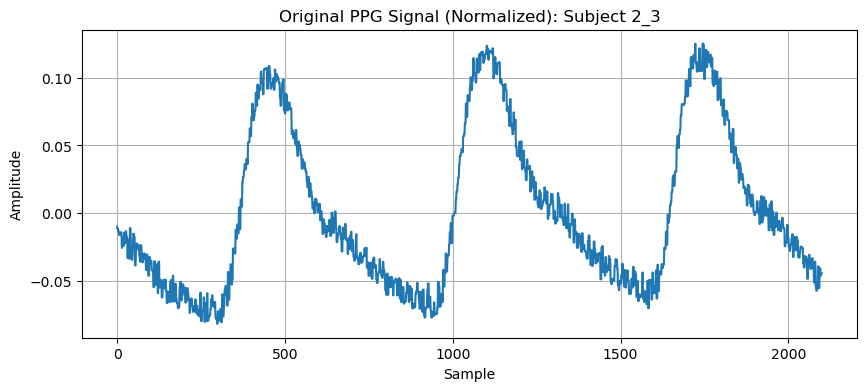

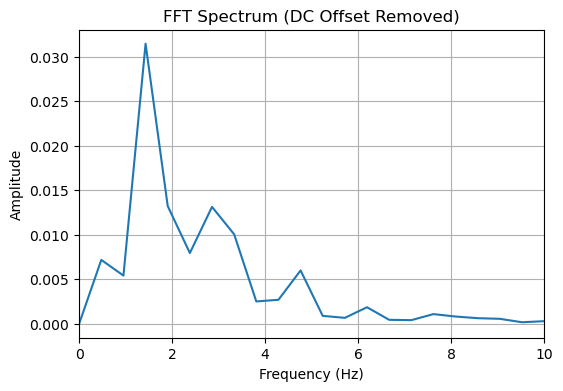

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import os

folder_normalized = '../../dataset/normalization/0_subjectSQI_normalized'
subject_file = '2_3.txt'  # File của subject 2_3
file_path = os.path.join(folder_normalized, subject_file)

# Sampling rate và số điểm
sampling_rate = 1000

# Kiểm tra nếu file tồn tại
if os.path.exists(file_path):
    # Đọc tín hiệu từ file
    signal = np.loadtxt(file_path)

    # Số điểm trong tín hiệu
    N = len(signal)
    signal = signal - np.mean(signal)

    # Tính FFT
    fft_values = fft(signal)  # FFT trả về giá trị phức
    freqs = fftfreq(N, d=1/sampling_rate)  # Tần số tương ứng

    # Lấy phần phổ dương
    positive_freqs = freqs[:N // 2]
    fft_magnitude = np.abs(fft_values[:N // 2]) / N  # Chia tỷ lệ theo số điểm

    # Vẽ tín hiệu gốc (Normalized Signal)
    plt.figure(figsize=(10, 4))
    plt.plot(signal)
    plt.title("Original PPG Signal (Normalized): Subject 2_3")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

    # Vẽ FFT Spectrum
    plt.figure(figsize=(6, 4))
    plt.plot(positive_freqs, fft_magnitude)
    plt.title("FFT Spectrum (DC Offset Removed)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim([0, 10])
    plt.grid()
    plt.show()
else:
    print(f"File {subject_file} không tồn tại trong thư mục {folder_normalized}.")

In [15]:
dc_offset = np.mean(signal)
print(f"DC Offset: {dc_offset}")

DC Offset: 2.1992989440193578e-17


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram
from scipy.fft import fft, fftfreq

# Đường dẫn thư mục
folder_normalized = '../../dataset/normalization/0_subjectSQI_normalized'  # Thư mục chứa file normalize
images_spectrum = '../../images/images_spectrum'  # Thư mục lưu Spectrum
sampling_rate = 1000  # Sampling rate (Hz)

# Đảm bảo thư mục lưu Spectrum tồn tại
if not os.path.exists(images_spectrum):
    os.makedirs(images_spectrum)

def plot_fft(signal, save_path, sampling_rate=1000):
    # Loại bỏ DC Offset
    signal = signal - np.mean(signal)
    # Tính FFT
    N = len(signal)
    freq = fftfreq(N, d=1/sampling_rate)
    fft_values = fft(signal)
    positive_freqs = freq[:N // 2]
    fft_magnitude = np.abs(fft_values[:N // 2])

    # Vẽ phổ FFT
    plt.figure(figsize=(6, 4))
    plt.plot(positive_freqs, fft_magnitude)
    plt.title("FFT Spectrum (DC Offset Removed)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim([0, 10])
    plt.grid()
    plt.savefig(save_path)
    plt.close()

# Hàm vẽ PSD
def plot_psd(signal, save_path):
    freqs, psd = welch(signal, fs=sampling_rate, nperseg=256)
    
    plt.figure(figsize=(6, 4))
    plt.semilogy(freqs, psd)
    plt.title("PSD Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid()
    plt.savefig(save_path)
    plt.close()

# Hàm vẽ Spectrogram
def plot_spectrogram(signal, save_path):
    f, t, Sxx = spectrogram(signal, fs=sampling_rate, nperseg=256, noverlap=128)
    
    plt.figure(figsize=(6, 4))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='jet')
    plt.title("Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Power (dB)")
    plt.savefig(save_path)
    plt.close()

# Lặp qua từng file normalize và vẽ Spectrum
for file_name in os.listdir(folder_normalized):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_normalized, file_name)

        # Đọc tín hiệu từ file
        signal = np.loadtxt(file_path)

        # Tạo thư mục lưu ảnh spectrum
        subject_id = file_name.replace('.txt', '')  # Bỏ phần mở rộng
        subject_folder = os.path.join(images_spectrum, subject_id)
        if not os.path.exists(subject_folder):
            os.makedirs(subject_folder)

        # Lưu các Spectrum
        fft_path = os.path.join(subject_folder, f"{subject_id}_FFT.png")
        psd_path = os.path.join(subject_folder, f"{subject_id}_PSD.png")
        spectrogram_path = os.path.join(subject_folder, f"{subject_id}_Spectrogram.png")

        # Vẽ FFT
        plot_fft(signal, fft_path)
        # Vẽ PSD
        plot_psd(signal, psd_path)
        # Vẽ Spectrogram
        plot_spectrogram(signal, spectrogram_path)

        print(f"Lưu phổ FFT, PSD, và Spectrogram cho Subject {subject_id}")

Lưu phổ FFT, PSD, và Spectrogram cho Subject 100_2
Lưu phổ FFT, PSD, và Spectrogram cho Subject 103_2
Lưu phổ FFT, PSD, và Spectrogram cho Subject 104_1
Lưu phổ FFT, PSD, và Spectrogram cho Subject 105_3
Lưu phổ FFT, PSD, và Spectrogram cho Subject 106_3
Lưu phổ FFT, PSD, và Spectrogram cho Subject 107_2
Lưu phổ FFT, PSD, và Spectrogram cho Subject 108_1
Lưu phổ FFT, PSD, và Spectrogram cho Subject 10_1
Lưu phổ FFT, PSD, và Spectrogram cho Subject 110_1
Lưu phổ FFT, PSD, và Spectrogram cho Subject 111_2
Lưu phổ FFT, PSD, và Spectrogram cho Subject 112_3
Lưu phổ FFT, PSD, và Spectrogram cho Subject 113_3
Lưu phổ FFT, PSD, và Spectrogram cho Subject 114_3
Lưu phổ FFT, PSD, và Spectrogram cho Subject 115_3
Lưu phổ FFT, PSD, và Spectrogram cho Subject 116_1
Lưu phổ FFT, PSD, và Spectrogram cho Subject 119_1
Lưu phổ FFT, PSD, và Spectrogram cho Subject 11_1
Lưu phổ FFT, PSD, và Spectrogram cho Subject 120_3
Lưu phổ FFT, PSD, và Spectrogram cho Subject 122_1
Lưu phổ FFT, PSD, và Spectrogram 

## 4.2 Spectrum total psd 0-50hz

In [17]:
# # Cell: Tính tổng giá trị PSD trong khoảng 0-50 Hz cho một bệnh nhân

# # Hàm tính tổng PSD từ 0 đến 50 Hz
# def compute_psd_total_0_50hz(signal, sampling_rate=1000, fmin=0, fmax=50):
#     # Tính PSD của tín hiệu
#     freq, psd = apply_psd(signal)  # Giả sử hàm apply_psd đã được định nghĩa
    
#     # Lọc các giá trị PSD trong khoảng tần số từ 0 đến 50 Hz
#     mask = (freq >= fmin) & (freq <= fmax)
#     freq_filtered = freq[mask]
#     psd_filtered = psd[mask]
    
#     # Tính tổng PSD trong khoảng này bằng phương pháp tích phân hình thang
#     psd_total = np.trapz(psd_filtered, freq_filtered)
    
#     return psd_total

# # Áp dụng tính toán cho một bệnh nhân cụ thể
# subject_id = df.iloc[0]['Subject_ID']  # Lấy ví dụ bệnh nhân đầu tiên
# max_signal = df.iloc[0]['Max SQI Signal']
# label = df.iloc[0]['Label']

# # Đảm bảo nhãn khớp với tên thư mục
# label_folder_name = category_mapping.get(label, label)

# # Lấy loại tín hiệu từ Max SQI Signal
# signal_type = max_signal.split('sig')[-1]
# image_filename = f"{subject_id}_{signal_type}.png"
# image_path = os.path.join(images_signal, label_folder_name, image_filename)

# # Kiểm tra file ảnh tồn tại trước khi thực hiện các bước tiếp theo
# if os.path.exists(image_path):
#     signal = extract_signal_from_image(image_path)
#     psd_total_0_50hz = compute_psd_total_0_50hz(signal)
#     print(f"Tổng PSD từ 0-50 Hz cho Subject {subject_id}: {psd_total_0_50hz}")
# else:
#     print(f"File {image_path} không tồn tại.")